# PALM drift correction test

Testing the idea of automatically finding peaks and then drift correcting all of them at once.

In [1]:
import gc
import numpy as np
import pandas as pd
# regular plotting
%matplotlib inline
import matplotlib.pyplot as plt

# data loading
from scipy.io import readsav
from skimage.external import tifffile as tif

# get multiprocessing support
import dask
from dask.diagnostics import ProgressBar
import dask.multiprocessing

# need to be able to remove fiducials
from peaks.peakfinder import PeakFinder
import tqdm

# Need partial
from functools import partial

from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2
from palm_diagnostics import peakselector_df, calc_bins, PALMExperiment

In [3]:
def peakselector_df(path, verbose=False):
    """Read a peakselector file into a pandas dataframe"""
    print("Reading {} into memory ... ".format(path))
    sav = readsav(path, verbose=verbose)
    print(sav["totalrawdata"].shape)
    # pull out cgroupparams, set the byteorder to native and set the rownames
    df = pd.DataFrame(sav["cgroupparams"].byteswap().newbyteorder(), columns=sav["rownames"].astype(str))
    return df

In [4]:
df_raw = peakselector_df("../../ORCA_Data/20170425/pHluorinPALM_Cell1/Run1_IDL.sav")

Reading ../../ORCA_Data/20170425/pHluorinPALM_Cell1/Run1_IDL.sav into memory ... 
(512, 512)


In [5]:
df_raw.head()

,Offset,Amplitude,X Position,Y Position,X Peak Width,Y Peak Width,6 N Photons,ChiSquared,FitOK,Frame Number,...,Group N Photons,24 Group Size,Frame Index in Grp,Label Set,XY Ellipticity,Z Position,Sigma Z,XY Group Ellipticity,Group Z Position,Group Sigma Z
0,137.579773,530.238586,343.673309,274.506226,1.136144,1.009693,3821.0,907.231506,1.0,0.0,...,0.0,0.0,0.0,0.0,0.058928,0.0,0.0,0.0,0.0,0.0
1,131.711044,459.056885,331.923309,325.616913,1.068535,1.139503,3511.0,530.384583,1.0,0.0,...,0.0,0.0,0.0,0.0,-0.032141,0.0,0.0,0.0,0.0,0.0
2,139.097961,282.813110,366.131287,241.023758,2.251247,1.277195,5032.0,796.745728,1.0,0.0,...,0.0,0.0,0.0,0.0,0.276057,0.0,0.0,0.0,0.0,0.0
3,136.202606,283.897736,365.585938,375.639099,2.154221,1.011945,3849.0,612.831970,1.0,0.0,...,0.0,0.0,0.0,0.0,0.360776,0.0,0.0,0.0,0.0,0.0
4,150.478867,345.975433,360.689911,308.011902,1.186007,1.061628,2737.0,515.257874,1.0,0.0,...,0.0,0.0,0.0,0.0,0.055337,0.0,0.0,0.0,0.0,0.0


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13907666 entries, 0 to 13907665
Data columns (total 31 columns):
Offset                  float32
Amplitude               float32
X Position              float32
Y Position              float32
X Peak Width            float32
Y Peak Width            float32
6 N Photons             float32
ChiSquared              float32
FitOK                   float32
Frame Number            float32
Peak Index of Frame     float32
12 X PkW * Y PkW        float32
Sigma X Pos rtNph       float32
Sigma Y Pos rtNph       float32
Sigma X Pos Full        float32
Sigma Y Pos Full        float32
18 Grouped Index        float32
Group X Position        float32
Group Y Position        float32
Group Sigma X Pos       float32
Group Sigma Y Pos       float32
Group N Photons         float32
24 Group Size           float32
Frame Index in Grp      float32
Label Set               float32
XY Ellipticity          float32
Z Position              float32
Sigma Z              

In [7]:
df_raw.head()

,Offset,Amplitude,X Position,Y Position,X Peak Width,Y Peak Width,6 N Photons,ChiSquared,FitOK,Frame Number,...,Group N Photons,24 Group Size,Frame Index in Grp,Label Set,XY Ellipticity,Z Position,Sigma Z,XY Group Ellipticity,Group Z Position,Group Sigma Z
0,137.579773,530.238586,343.673309,274.506226,1.136144,1.009693,3821.0,907.231506,1.0,0.0,...,0.0,0.0,0.0,0.0,0.058928,0.0,0.0,0.0,0.0,0.0
1,131.711044,459.056885,331.923309,325.616913,1.068535,1.139503,3511.0,530.384583,1.0,0.0,...,0.0,0.0,0.0,0.0,-0.032141,0.0,0.0,0.0,0.0,0.0
2,139.097961,282.813110,366.131287,241.023758,2.251247,1.277195,5032.0,796.745728,1.0,0.0,...,0.0,0.0,0.0,0.0,0.276057,0.0,0.0,0.0,0.0,0.0
3,136.202606,283.897736,365.585938,375.639099,2.154221,1.011945,3849.0,612.831970,1.0,0.0,...,0.0,0.0,0.0,0.0,0.360776,0.0,0.0,0.0,0.0,0.0
4,150.478867,345.975433,360.689911,308.011902,1.186007,1.061628,2737.0,515.257874,1.0,0.0,...,0.0,0.0,0.0,0.0,0.055337,0.0,0.0,0.0,0.0,0.0


In [8]:
def filter_peaks(df, offset=1000, sigma_max=3, nphotons=0, amp=0, groupsize=5000):
    """Filter internal dataframes"""
    filter_series = (
        (df.offset > 0) & # we know that offset should be around this value.
        (df.offset < offset) &
        (df.sigmax < sigma_max) &
        (df.sigmay < sigma_max) &
        (df.nphotons > nphotons) &
        (df.amp > amp)
    )
    if "groupsize" in df.keys():
        filter_series &= df.groupsize < groupsize
    return df[filter_series]

In [9]:
peak_col = {
    'X Position': "xpos",
    'Y Position': "ypos",
    '6 N Photons': "nphotons",
    'Frame Number': "framenum",
    'Sigma X Pos Full': "sigmax",
    'Sigma Y Pos Full': "sigmay",
    'Z Position': 'zpos',
    'Offset': 'offset',
    'Amplitude': 'amp'
}
df_clean = df_raw[list(peak_col.keys())]
# self.grouped = grouped_peaks(raw_df)[list(self.group_col.keys())]
# normalize column names
df_clean = df_clean.rename(columns=peak_col)
# self.grouped = self.grouped.rename(columns=self.group_col)
df_filtered = filter_peaks(df_clean, amp=100)

In [104]:
def make_hist(df, data_shape, subsampling=10):
    # ungrouped 2d histogram to find peaks, ungrouped to make beads really stand out
    ybins, xbins = calc_bins(np.empty(data_shape), subsampling)
    hist_2d = np.histogramdd(df[["ypos", "xpos"]].values, bins=(ybins, xbins))[0]
    return hist_2d

In [25]:
def find_fiducials(df, data_shape, thresh=50, sigma=4, subsampling=10, diagnostics=False):
    # ungrouped 2d histogram to find peaks, ungrouped to make beads really stand out
    ybins, xbins = calc_bins(np.empty(data_shape), subsampling)
    hist_2d = np.histogramdd(df[["ypos", "xpos"]].values, bins=(ybins, xbins))[0]
    pf = PeakFinder(hist_2d, sigma * subsampling)
    pf.thresh = thresh / subsampling
    # pf.plot_blobs(vmax=20, cmap="inferno", norm=LogNorm(), size=10)
    # pf.plot_blob_grid(20, cmap="inferno")
    sub_sample_xy = ybins[1] - ybins[0]
    # find blobs
    pf.find_blobs()
    pf.remove_edge_blobs(sigma)
    if diagnostics:
        pf._blobs[:, 3] = np.arange(len(pf.blobs))
        pf.plot_blobs(size=12, norm=LogNorm())
    return pf.blobs[:, :2] / subsampling

[[  8.40000000e+01   3.57400000e+03   2.50000000e+01   0.00000000e+00]
 [  1.67200000e+03   4.95700000e+03   2.50000000e+01   1.00000000e+00]
 [  1.22800000e+03   4.84800000e+03   2.50000000e+01   2.00000000e+00]
 [  1.71000000e+02   4.29700000e+03   2.50000000e+01   3.00000000e+00]
 [  1.10300000e+03   4.41900000e+03   2.50000000e+01   4.00000000e+00]
 [  1.36200000e+03   2.97900000e+03   2.50000000e+01   5.00000000e+00]
 [  1.50900000e+03   5.01600000e+03   2.50000000e+01   6.00000000e+00]
 [  2.78000000e+02   4.34900000e+03   2.50000000e+01   7.00000000e+00]
 [  5.03000000e+02   3.81200000e+03   2.50000000e+01   8.00000000e+00]
 [  1.29000000e+03   4.92200000e+03   2.50000000e+01   9.00000000e+00]
 [  6.01000000e+02   3.56100000e+03   2.50000000e+01   1.00000000e+01]
 [  1.16000000e+03   5.06700000e+03   2.50000000e+01   1.10000000e+01]
 [  4.90000000e+02   5.07900000e+03   2.50000000e+01   1.20000000e+01]
 [  1.37900000e+03   4.86700000e+03   2.50000000e+01   1.30000000e+01]
 [  1.

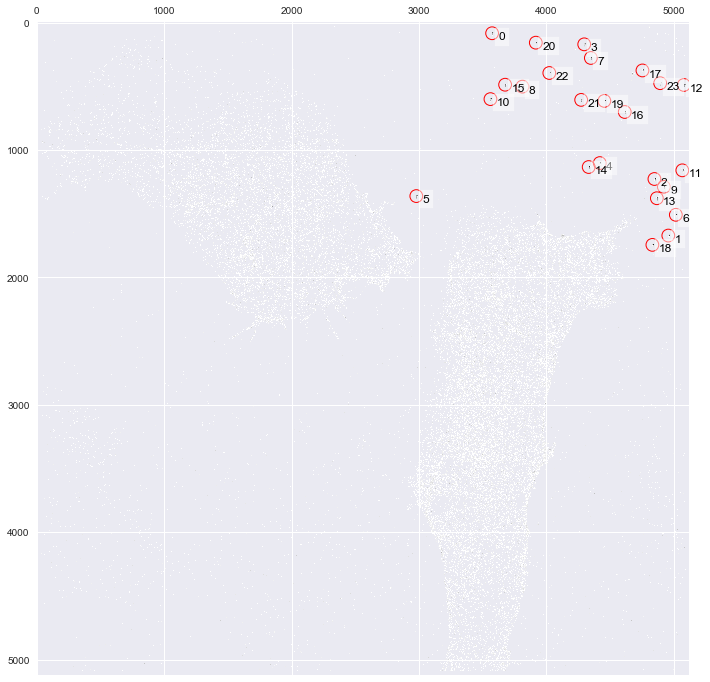

In [26]:
%time b = find_fiducials(df_filtered, (10, 512, 512), subsampling=10, thresh=1000, sigma=4, diagnostics=True)

In [27]:
def extract_fiducials(df, blobs, radius, max_fiducials=None):
    """Do the actual filtering
    
    We're doing it sequentially because we may run out of memory.
    If initial DataFrame is 18 GB (1 GB per column) and we have 200 """
    s = slice(max_fiducials)
    fiducials_dfs = [df[np.sqrt((df.xpos - x) ** 2 + (df.ypos - y) ** 2) < radius]
        for y, x in tqdm.tqdm_notebook(blobs[s], leave=False, desc="Extracting Fiducials")]
    # remove any duplicates in a given frame by only keeping the localization with the largest count
    return fiducials_dfs

In [28]:
len(df_filtered) / len(df_clean)

0.37385101137746624

In [34]:
fiducials_dfs = extract_fiducials(df_filtered, b, 4)

In [35]:
clean_fiducials = [sub_df.sort_values('amp', ascending=False).groupby('framenum').first() for sub_df in fiducials_dfs if len(sub_df)]

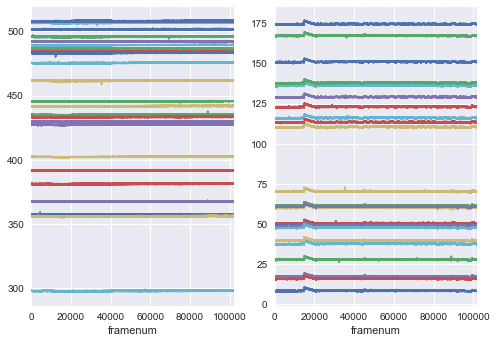

In [253]:
fig, (ax0, ax1) = plt.subplots(1, 2)
for ff in clean_fiducials:
    ff.xpos.plot(ax=ax0)
    ff.ypos.plot(ax=ax1)

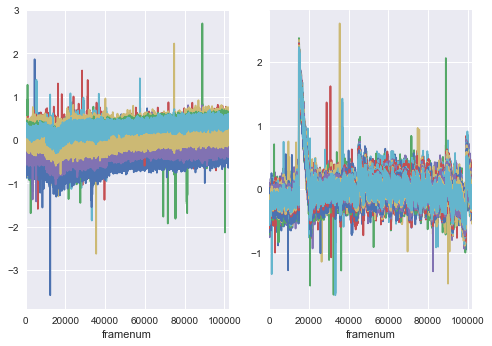

In [254]:
fig, (ax0, ax1) = plt.subplots(1, 2)
for ff in clean_fiducials:
    (ff.xpos - ff.xpos.mean()).plot(ax=ax0)
    (ff.ypos - ff.ypos.mean()).plot(ax=ax1)

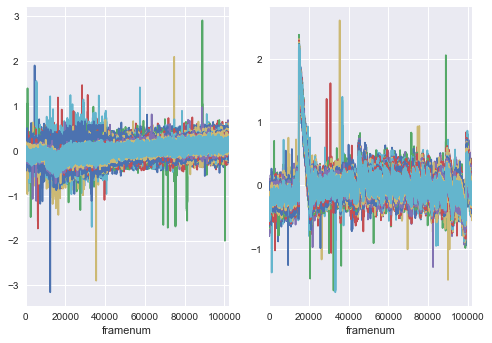

In [255]:
fig, (ax0, ax1) = plt.subplots(1, 2)
for ff in clean_fiducials:
    (ff.xpos - ff.xpos.astype(float).mean()).plot(ax=ax0)
    (ff.ypos - ff.ypos.astype(float).mean()).plot(ax=ax1)

In [238]:
mean_removed = pd.concat([(ff[["ypos", "xpos"]] - ff[["ypos", "xpos"]].astype(np.float32).mean())
                          for ff in clean_fiducials])

In [239]:
df_dc.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 102100 entries, 0.0 to 102099.0
Data columns (total 2 columns):
ypos    102100 non-null float64
xpos    102100 non-null float64
dtypes: float64(2)
memory usage: 7.3 MB


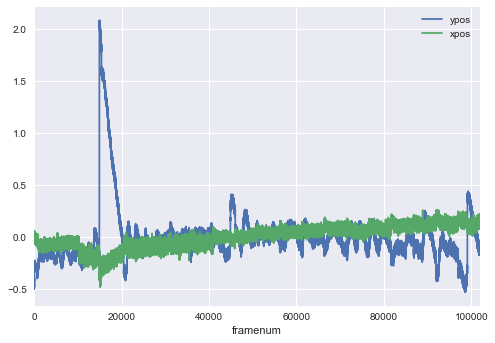

In [240]:
# have to convert to float, single precision isn't enough to do proper drift correction.
df_dc = mean_removed.groupby("framenum").mean()
df_dc = df_dc - df_dc.mean()
df_dc.plot()

ypos    0.286532
xpos    0.254182
dtype: float32

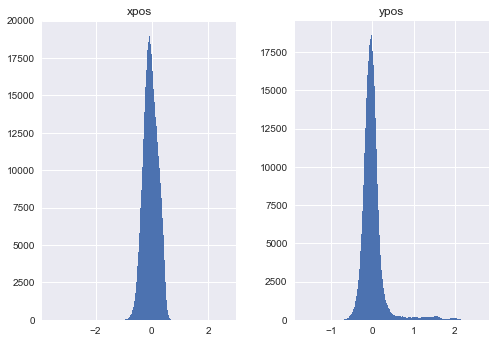

In [241]:
mean_removed.hist(bins="auto")
mean_removed.std()

In [242]:
df_clean_dc = df_clean.set_index("framenum") - df_dc

In [243]:
junk_hist = make_hist(df_clean_dc, (10, 512, 512))

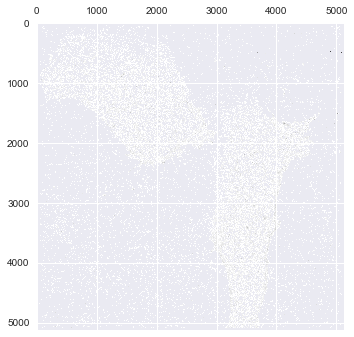

In [244]:
plt.matshow(junk_hist, norm=LogNorm())

In [245]:
df_filtered_dc = df_filtered.set_index("framenum") - df_dc

[[  1.10300000e+03   4.41900000e+03   2.50000000e+01   0.00000000e+00]
 [  1.67300000e+03   4.95800000e+03   2.50000000e+01   1.00000000e+00]
 [  1.29100000e+03   4.92200000e+03   2.50000000e+01   2.00000000e+00]
 [  8.40000000e+01   3.57400000e+03   2.50000000e+01   3.00000000e+00]
 [  1.22900000e+03   4.84800000e+03   2.50000000e+01   4.00000000e+00]
 [  1.71000000e+02   4.29700000e+03   2.50000000e+01   5.00000000e+00]
 [  1.50900000e+03   5.01500000e+03   2.50000000e+01   6.00000000e+00]
 [  5.04000000e+02   3.81200000e+03   2.50000000e+01   7.00000000e+00]
 [  1.36200000e+03   2.97900000e+03   2.50000000e+01   8.00000000e+00]
 [  4.90000000e+02   5.07900000e+03   2.50000000e+01   9.00000000e+00]
 [  1.74500000e+03   4.83200000e+03   2.50000000e+01   1.00000000e+01]
 [  2.78000000e+02   4.34900000e+03   2.50000000e+01   1.10000000e+01]
 [  6.01000000e+02   3.56100000e+03   2.50000000e+01   1.20000000e+01]
 [  1.13400000e+03   4.33200000e+03   2.50000000e+01   1.30000000e+01]
 [  1.

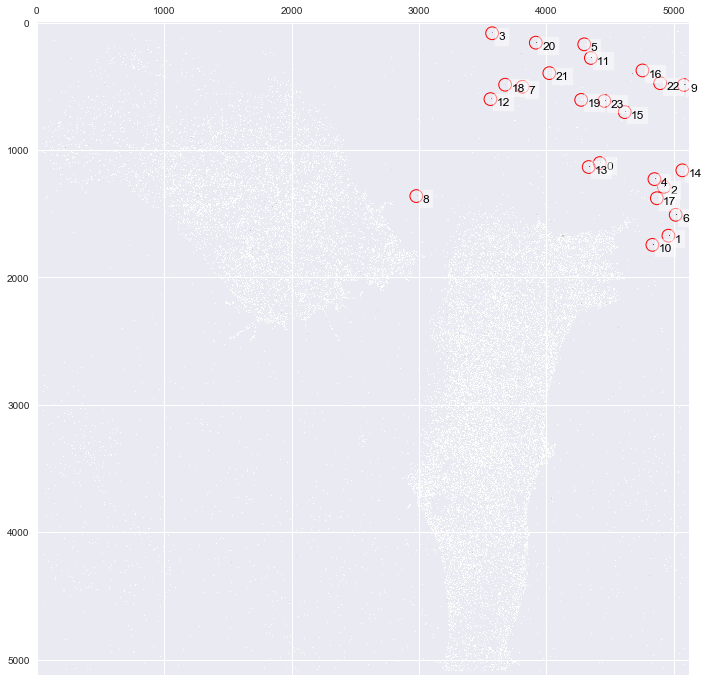

In [246]:
%time b2 = find_fiducials(df_filtered_dc, (10, 512, 512), subsampling=10, thresh=1000, sigma=4, diagnostics=True)

In [247]:
fiducials_dfs2 = extract_fiducials(df_filtered_dc, b2, 4)

In [248]:
clean_fiducials2 = [sub_df.sort_values('amp', ascending=False).groupby('framenum').first()
                    for sub_df in fiducials_dfs2 if len(sub_df)]

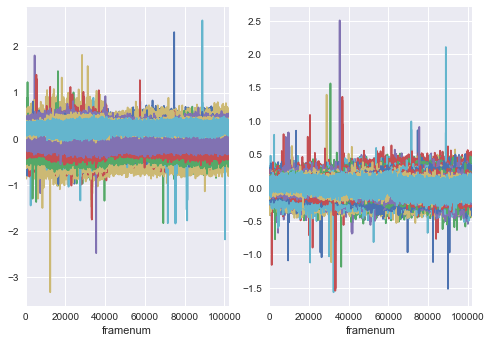

In [249]:
fig, (ax0, ax1) = plt.subplots(1, 2)
for ff in clean_fiducials2:
    (ff.xpos - ff.xpos.mean()).plot(ax=ax0)
    (ff.ypos - ff.ypos.mean()).plot(ax=ax1)

In [250]:
mean_removed2 = pd.concat([(ff[["ypos", "xpos"]] - ff[["ypos", "xpos"]].mean())
                 for ff in clean_fiducials2])

ypos    0.286532
xpos    0.254182
dtype: float32
ypos    0.096703
xpos    0.242792
dtype: float32


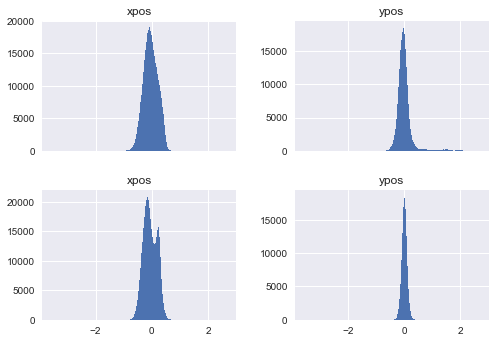

In [261]:
fig, (ax0, ax1) = plt.subplots(2,2, sharex=True)
mean_removed.hist(bins="auto", ax=ax0)
print(mean_removed.std())
mean_removed2.hist(bins="auto", ax=ax1)
print(mean_removed2.std())

In [265]:
mean_removed2.groupby("framenum").mean().rolling(100, center=True, min_periods=1, win_type="boxcar").mean().info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 102100 entries, 0.0 to 102099.0
Data columns (total 2 columns):
ypos    102100 non-null float64
xpos    102100 non-null float64
dtypes: float64(2)
memory usage: 2.3 MB


ypos    0.004800
xpos    0.011907
dtype: float32

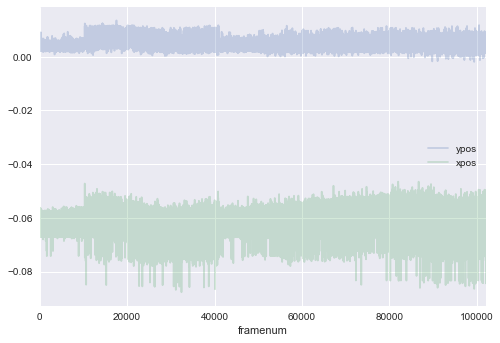

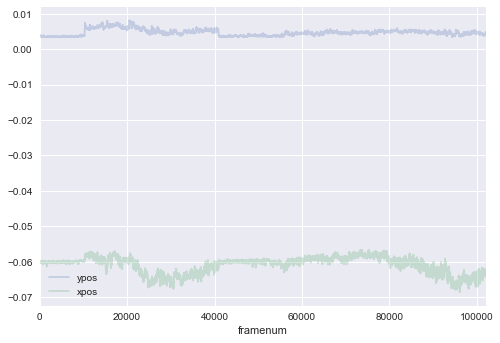

In [266]:
(mean_removed2.groupby("framenum").mean()).plot(alpha=0.25)
junk = mean_removed2.groupby("framenum").mean().rolling(100, center=True, min_periods=1, win_type="boxcar").mean().astype(np.float32)
junk.plot(alpha=0.25)
junk.max()-junk.min()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023BC3D84390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000023B281C3978>]], dtype=object)

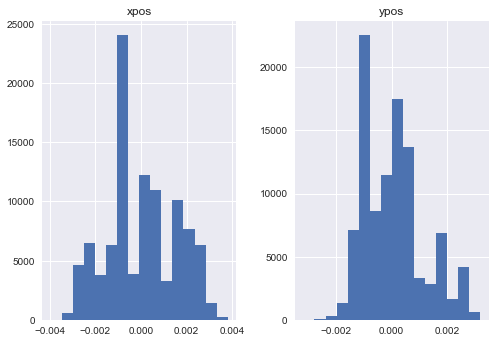

In [235]:
mean_removed2.groupby("framenum").mean().hist(bins=16)

ypos    0.286270
xpos    0.151881
dtype: float64
ypos    0.090945
xpos    0.107748
dtype: float64


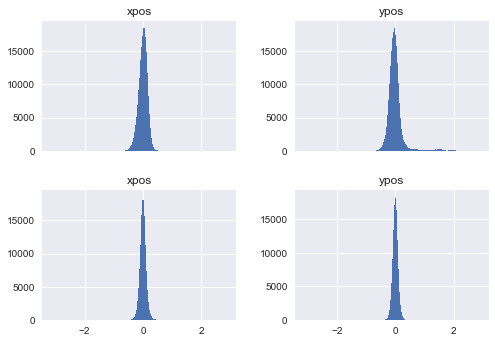

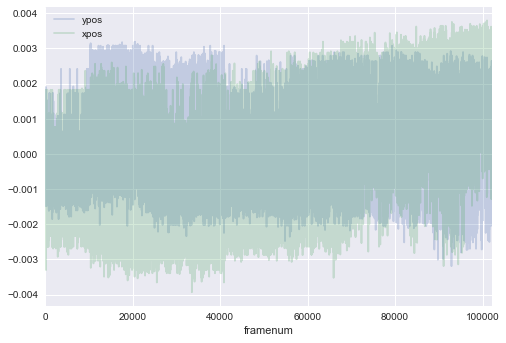

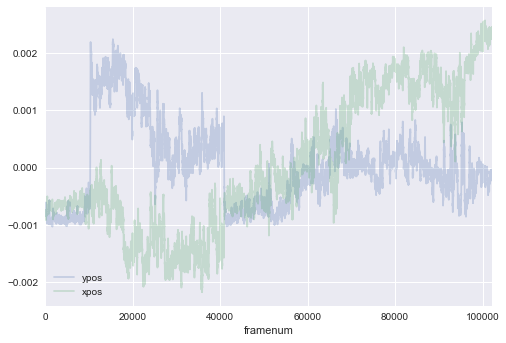

In [236]:
fig, (ax0, ax1) = plt.subplots(2,2, sharex=True)
mean_removed.hist(bins="auto", ax=ax0)
print(mean_removed.std())
mean_removed2.hist(bins="auto", ax=ax1)
print(mean_removed2.std())
(mean_removed2.groupby("framenum").mean()).plot(alpha=0.25)
junk = mean_removed2.groupby("framenum").mean().rolling(100, center=True, min_periods=1, win_type="boxcar").mean()
junk.plot(alpha=0.25)

In [258]:
print(np.float32(500.112222))

500.112


In [259]:
%precision

'%r'